# Notebook 6: FastAI Data Augmentation Capabilities

This notebook explores the powerful data augmentation features in the FastAI library. FastAI provides a streamlined, high-level API that integrates data augmentation techniques into the model training workflow. We'll demonstrate key augmentation capabilities including transform pipelines, test-time augmentation (TTA), and how to create custom transforms.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.8 MB/s eta 0:00:00


Dataset path: /root/.fastai/data/mnist_tiny


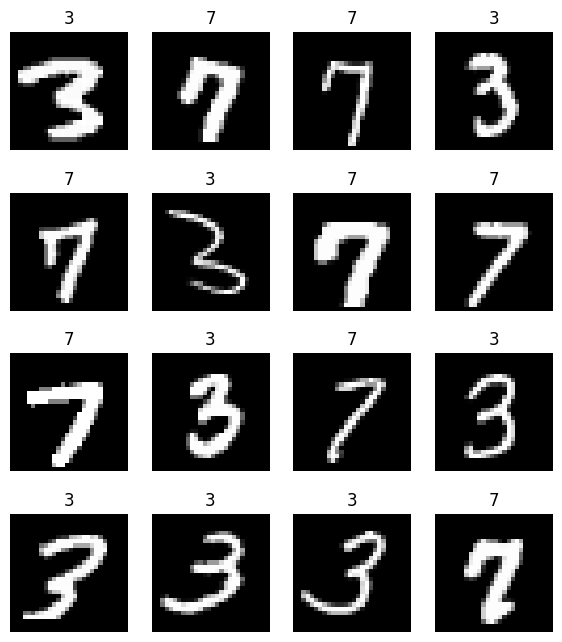

In [2]:
# Install FastAI
!pip install -q fastai
!pip install -q fastcore

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai.data.transforms import *

# Download a sample dataset (MNIST)
path = untar_data(URLs.MNIST_TINY)
print(f"Dataset path: {path}")

# Set up a DataBlock for the dataset
mnist = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(valid_name='val'),
    get_y=parent_label,
    item_tfms=Resize(28),
)

# Create a DataLoader with batch size 64
dls = mnist.dataloaders(path, bs=64)

# Show a batch of images
dls.show_batch(max_n=16, figsize=(7, 8))

## FastAI Transformations

FastAI organizes transformations into two categories:
1. `item_tfms`: Applied to individual items (like images) before batching
2. `batch_tfms`: Applied to batches, usually on the GPU for efficiency

We'll demonstrate both types and show how they affect our dataset.

Batch without augmentation:
Batch with augmentation:


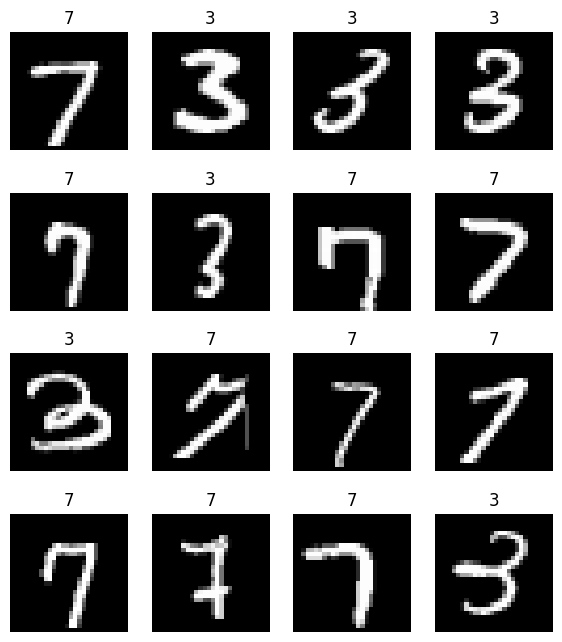

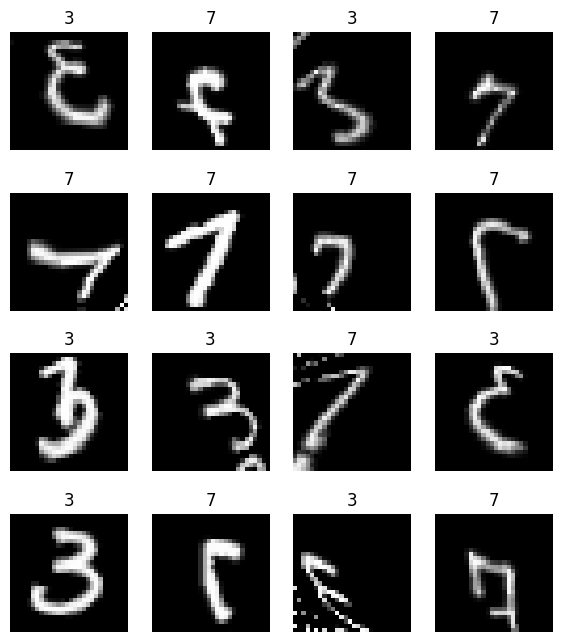

In [3]:
# Define common image augmentations
basic_transforms = [
    Resize(28),                    # Resize to 28x28 pixels
    ToTensor(),                    # Convert to PyTorch tensor
]

# Define more advanced augmentations at the batch level
aug_transforms = [
    *aug_transforms(mult=2.0),     # Standard augmentations with increased intensity
    Normalize.from_stats(*imagenet_stats)  # Normalize using ImageNet stats
]

# Create DataBlock with different augmentation strategies
# 1. No augmentation
basic_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(valid_name='val'),
    get_y=parent_label,
    item_tfms=basic_transforms,
)

# 2. With augmentation
aug_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(valid_name='val'),
    get_y=parent_label,
    item_tfms=basic_transforms,
    batch_tfms=aug_transforms,
)

# Create dataloaders
basic_dls = basic_dblock.dataloaders(path, bs=64)
aug_dls = aug_dblock.dataloaders(path, bs=64)

# Show a batch with no augmentation
print("Batch without augmentation:")
basic_dls.show_batch(max_n=16, figsize=(7, 8))

# Show a batch with augmentation
print("Batch with augmentation:")
aug_dls.show_batch(max_n=16, figsize=(7, 8))

## FastAI Transform Policies

FastAI provides various transform policies and preset combinations optimized for different tasks. Let's explore some of these transforms in more detail, including:

1. Built-in transform policies (e.g., aug_transforms)
2. Custom transform pipelines
3. Visualization of individual transforms

Item Transform: Standard Resize


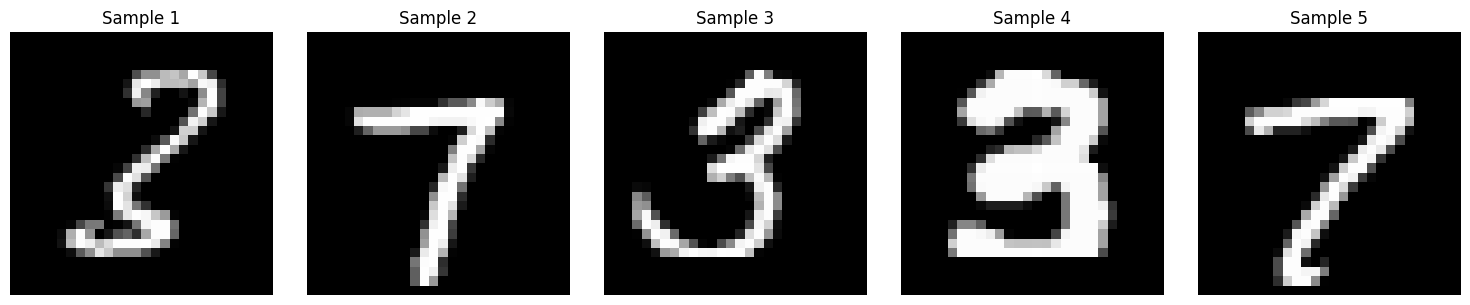

Item Transform: Squish


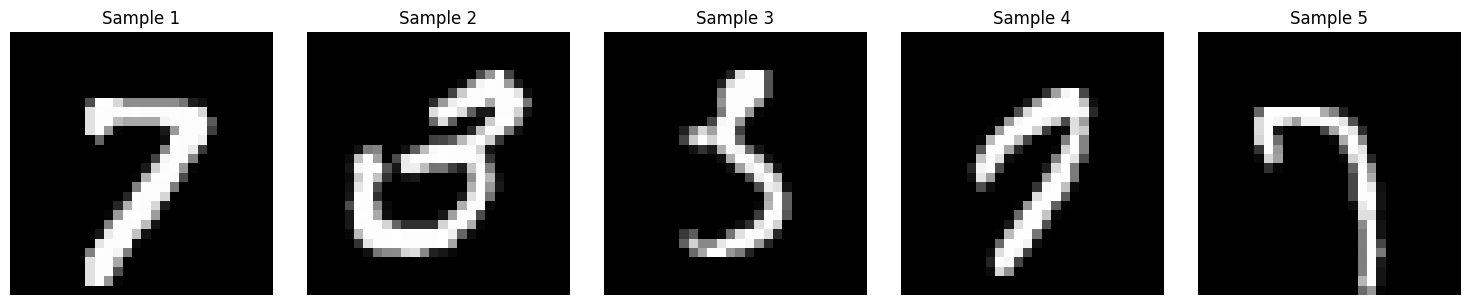

Item Transform: Pad with Zeros


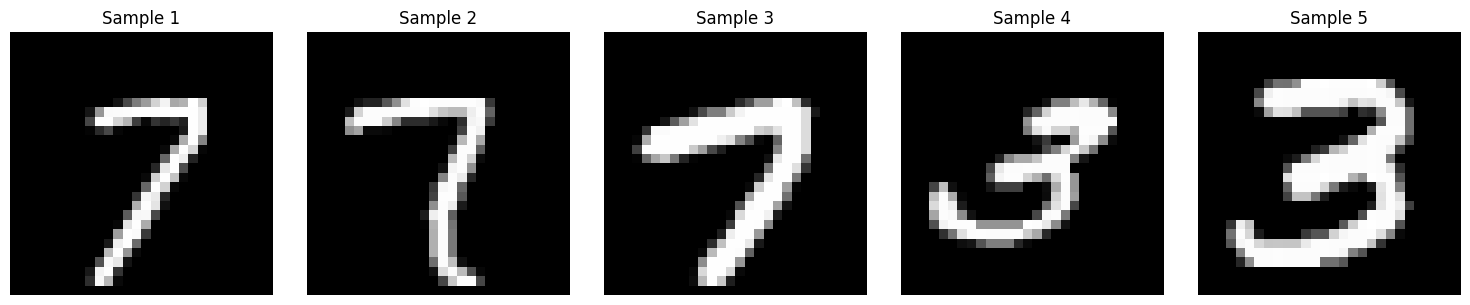

Item Transform: Center Crop


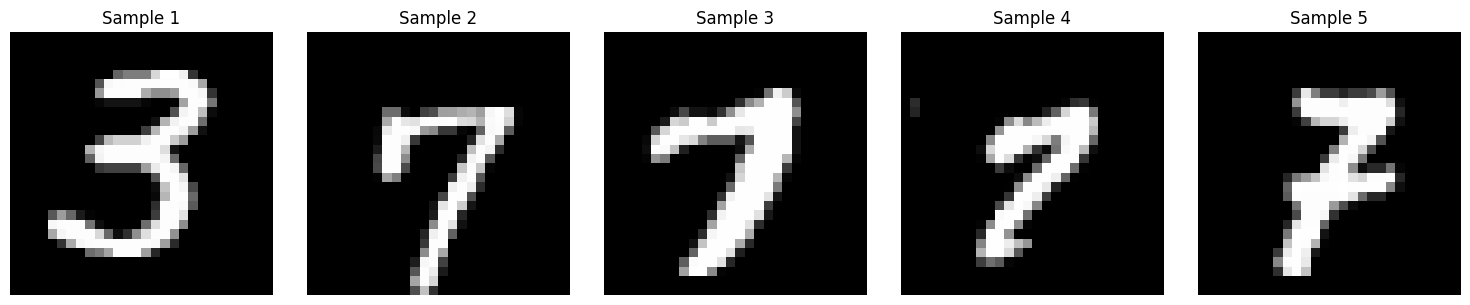

Item Transform: Random Resized Crop


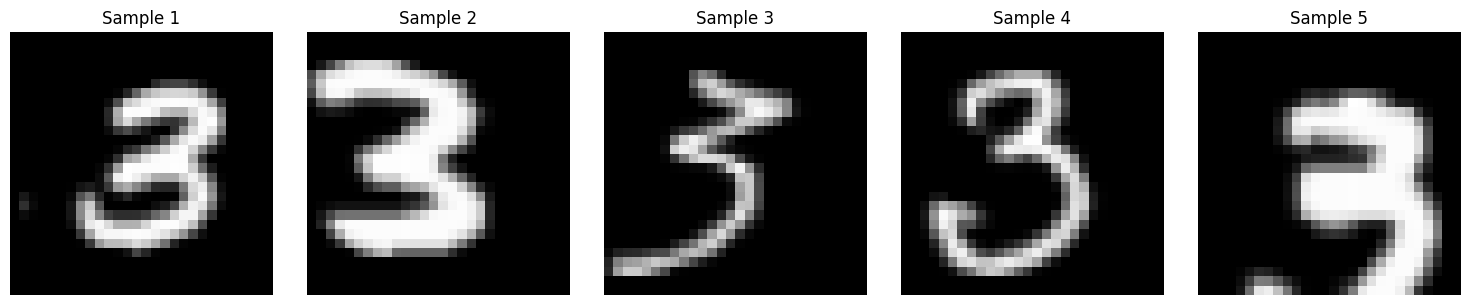

Batch Transform: Brightness


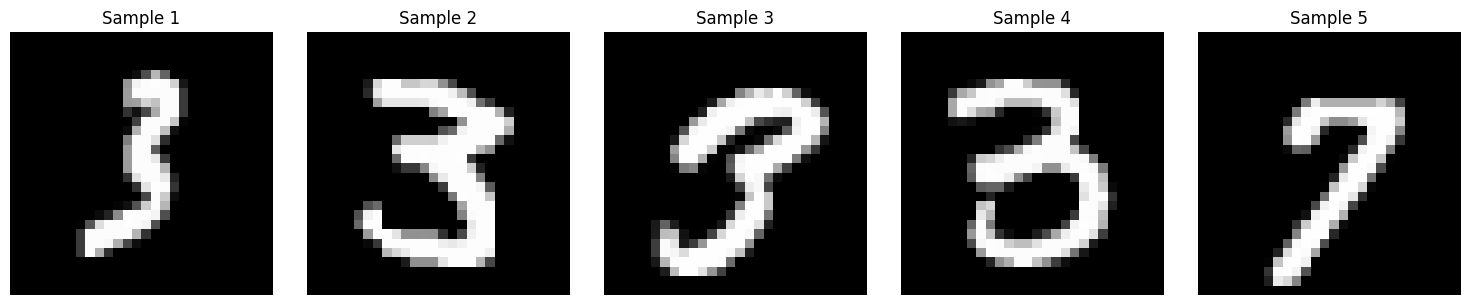

Batch Transform: Contrast


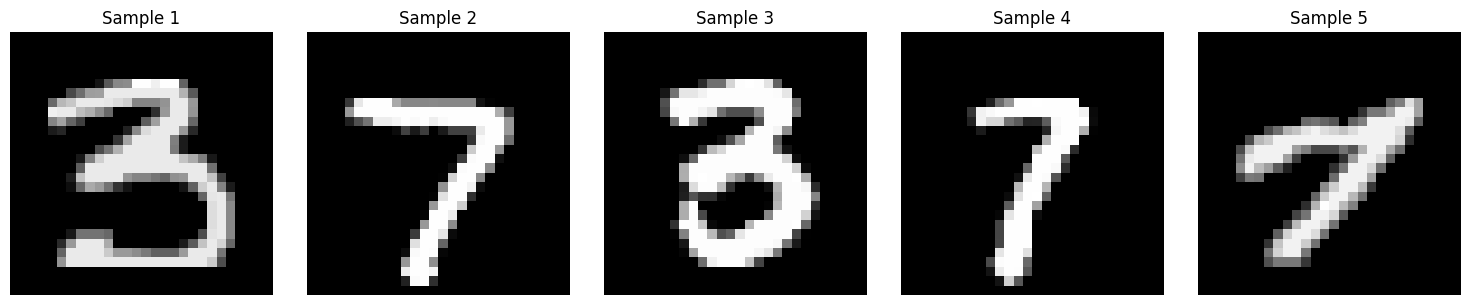

Batch Transform: Rotation


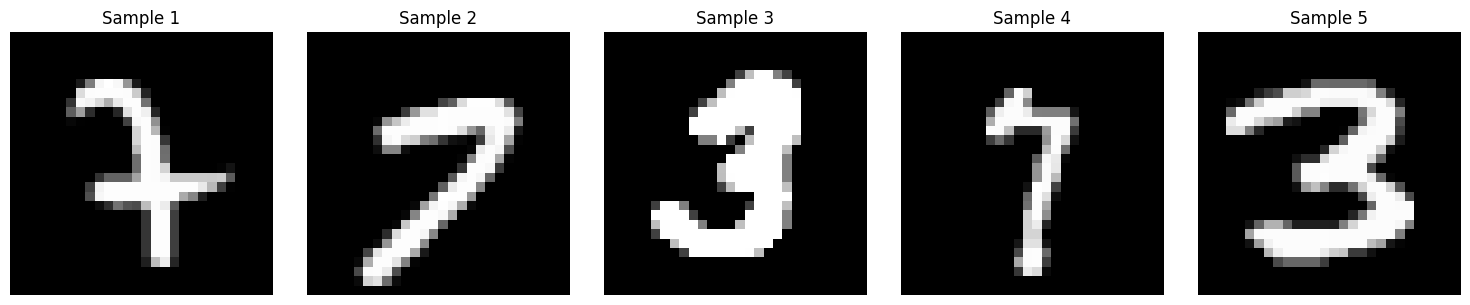

Batch Transform: Zoom


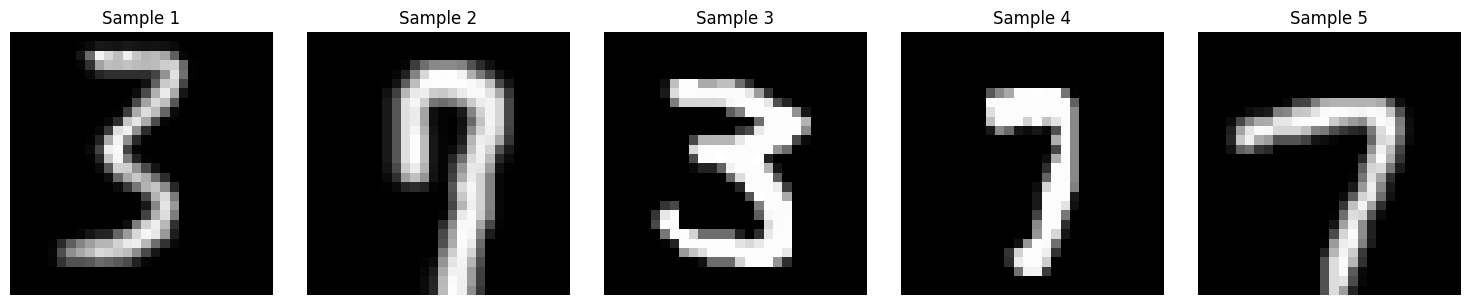

Batch Transform: Warp


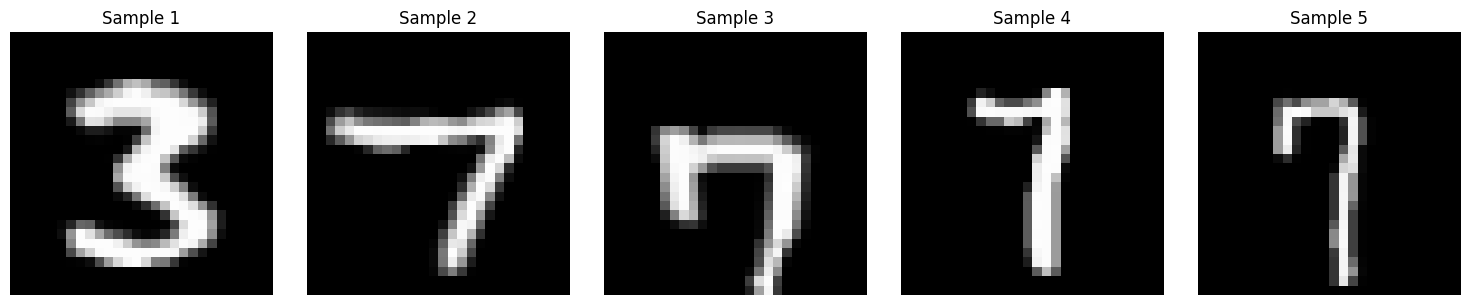

In [4]:
# Exploring transform combinations
# Create a function to display transforms
def show_transforms(item_tfms=None, batch_tfms=None, n_samples=5):
    """Show the effect of transforms on a few samples"""
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label,
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    dls = dblock.dataloaders(path, bs=n_samples)

    # Get a single batch
    batch = dls.one_batch()

    # Display the transformed images
    imgs = batch[0]
    _, axs = plt.subplots(1, n_samples, figsize=(15, 3))

    for i, ax in enumerate(axs):
        img = imgs[i]
        img = TensorImage(img)
        img.show(ctx=ax)
        ax.set_title(f"Sample {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 1. Show different item transforms
item_tfms_list = [
    [Resize(28)],
    [Resize(28, ResizeMethod.Squish)],
    [Resize(28, ResizeMethod.Pad, pad_mode='zeros')],
    [Resize(28, ResizeMethod.Crop)],
    [RandomResizedCrop(28, min_scale=0.5)]
]

item_names = [
    "Standard Resize",
    "Squish",
    "Pad with Zeros",
    "Center Crop",
    "Random Resized Crop"
]

for tfms, name in zip(item_tfms_list, item_names):
    print(f"Item Transform: {name}")
    show_transforms(item_tfms=tfms)

# 2. Show different batch transforms
batch_tfms_list = [
    [Brightness(max_lighting=0.5)],
    [Contrast(max_lighting=0.5)],
    [Rotate(max_deg=20)],
    [Zoom(max_zoom=1.5)],
    [Warp()]
]

batch_names = [
    "Brightness",
    "Contrast",
    "Rotation",
    "Zoom",
    "Warp"
]

for tfms, name in zip(batch_tfms_list, batch_names):
    print(f"Batch Transform: {name}")
    show_transforms(item_tfms=[Resize(28)], batch_tfms=tfms)